### Mount your drive and load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install graphviz
!pip install pydot

Mounted at /content/drive


In [5]:
import h5py
import numpy as np
import pandas as pd


def load_data(file_path):
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as hdf:
        # Load all data into memory
        input_data = hdf['input_data'][:]
        hedge_ratios = hdf['hedge_ratios'][:]
        stationarity_labels = hdf['stationarity_labels'][:]


    return input_data, hedge_ratios, stationarity_labels

# Specify the path to your HDF5 file
file_path = "/content/drive/My Drive/LSTM_NN_dataset.h5"
features, hedge_ratios, stationarities = load_data(file_path)
stationarities = stationarities.astype(int)

### Build Hedge Ratio Prediction Model


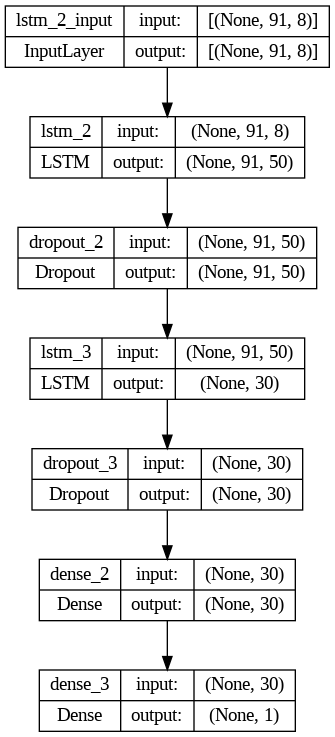

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Define model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(91, 8), return_sequences=True))  # Stacking LSTM layers
model.add(Dropout(0.2))  # Regularization with Dropout
model.add(LSTM(30, return_sequences=False))  # Final LSTM layer does not return sequences
model.add(Dropout(0.2))  # Additional Dropout for regularization
model.add(Dense(30, activation='relu'))  # Dense layer for additional learning capacity
model.add(Dense(1, activation=None))  # Output layer for regression, no activation function

# Compile the model for regression
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)



In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
# Assuming hedge_ratios is already loaded and prepared

# Splitting the data for regression task
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(features, hedge_ratios, test_size=0.2, random_state=42)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history_h = model.fit(X_train_h, y_train_h, epochs=50, batch_size=64,
                      validation_split=0.2,  # Using part of the training set for validation
                      callbacks=[early_stopping])


Epoch 1/50
2074/2074 [==============================] - 38s 13ms/step - loss: 2.6136 - mean_squared_error: 2.6136 - val_loss: 2.7992 - val_mean_squared_error: 2.7992
Epoch 2/50
2074/2074 [==============================] - 28s 13ms/step - loss: 2.4850 - mean_squared_error: 2.4850 - val_loss: 2.7864 - val_mean_squared_error: 2.7864
Epoch 3/50
2074/2074 [==============================] - 25s 12ms/step - loss: 2.4150 - mean_squared_error: 2.4150 - val_loss: 2.7026 - val_mean_squared_error: 2.7026
Epoch 4/50
2074/2074 [==============================] - 24s 12ms/step - loss: 2.4590 - mean_squared_error: 2.4590 - val_loss: 2.6880 - val_mean_squared_error: 2.6880
Epoch 5/50
2074/2074 [==============================] - 25s 12ms/step - loss: 2.4496 - mean_squared_error: 2.4496 - val_loss: 2.7791 - val_mean_squared_error: 2.7791
Epoch 6/50
2074/2074 [==============================] - 25s 12ms/step - loss: 2.4404 - mean_squared_error: 2.4404 - val_loss: 2.7758 - val_mean_squared_error: 2.7758
Epoc

In [ ]:
# Evaluate the model
mse = model.evaluate(X_test_h, y_test_h)
print(f"Mean Squared Error on Test set: {mse}")

# Making predictions
predicted_hedge_ratios = model.predict(X_test_h)


1297/1297 [==============================] - 6s 5ms/step - loss: 2.5811 - mean_squared_error: 2.5811
Mean Squared Error on Test set: [2.5810561180114746, 2.5810561180114746]
1297/1297 [==============================] - 6s 4ms/step


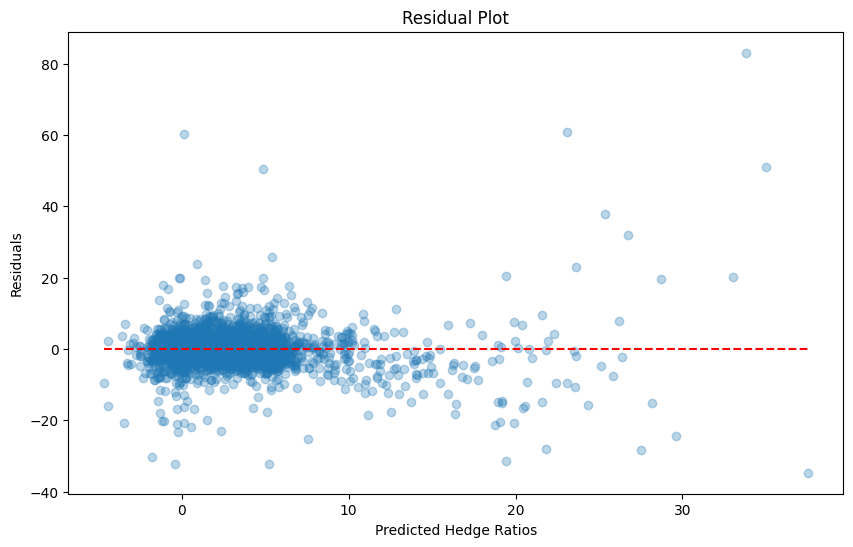

In [ ]:
import matplotlib.pyplot as plt
residuals = y_test_h - predicted_hedge_ratios.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(predicted_hedge_ratios, residuals, alpha=0.3)
plt.hlines(y=0, xmin=predicted_hedge_ratios.min(), xmax=predicted_hedge_ratios.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Hedge Ratios')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


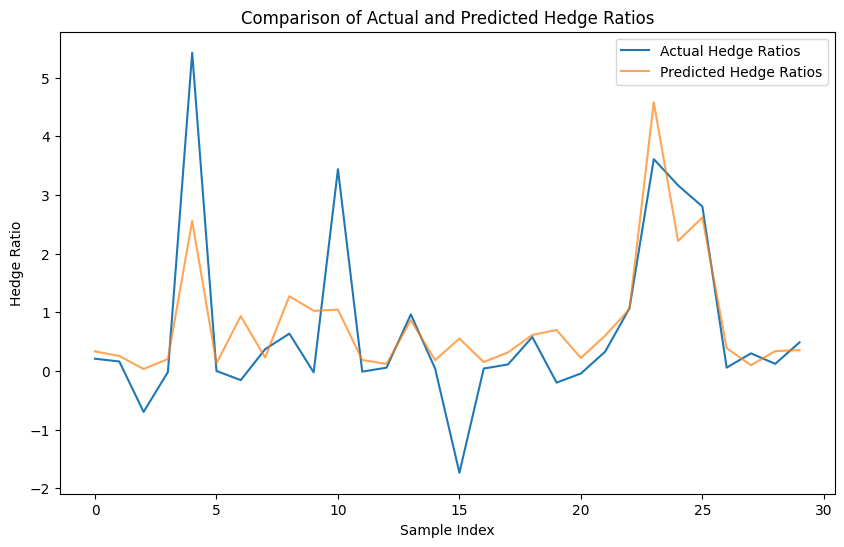

In [ ]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted hedge ratios
plt.figure(figsize=(10, 6))
plt.plot(y_test_h[:30], label='Actual Hedge Ratios')
plt.plot(predicted_hedge_ratios[:30], label='Predicted Hedge Ratios', alpha=0.7)
plt.title('Comparison of Actual and Predicted Hedge Ratios')
plt.xlabel('Sample Index')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Define the file path for saving the model
file_path = "/content/drive/My Drive/Model/hedgeratio_model.h5"

# Save the model
model.save(file_path)

# To load the model later
loaded_model = load_model(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loaded_model

### Build Stationarity Prediction Model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'stationarities' is your binary target array
class_weights = compute_class_weight('balanced', classes=np.unique(stationarities), y=stationarities)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# pd.Series(stationarities).value_counts(normalize = True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(91, 8), return_sequences=True))  # Enable return_sequences for stacking
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(30, return_sequences=False))  # Additional LSTM layer
model.add(Dropout(0.2))  # Additional Dropout layer
model.add(Dense(30, activation='relu'))  # Additional Dense layer for more complex patterns
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


from tensorflow.keras.metrics import AUC, Precision, Recall
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])


In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# First split: Separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(features, stationarities, test_size=0.2, random_state=42)

# del features
# del stationarities

# Second split: Separate out the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# # Train the model
# history = model.fit(X_train, y_train, epochs=50, batch_size=64,
#                     validation_data=(X_val, y_val),
#                     class_weight=class_weight_dict,
#                     callbacks=[early_stopping])


Epoch 1/50
2122/2122 [==============================] - 47s 16ms/step - loss: 0.6677 - accuracy: 0.5815 - precision: 0.2867 - recall: 0.6193 - auc: 0.6286 - val_loss: 0.6992 - val_accuracy: 0.5203 - val_precision: 0.2776 - val_recall: 0.7492 - val_auc: 0.6520
Epoch 2/50
2122/2122 [==============================] - 30s 14ms/step - loss: 0.6434 - accuracy: 0.6314 - precision: 0.3225 - recall: 0.6286 - auc: 0.6782 - val_loss: 0.6506 - val_accuracy: 0.6341 - val_precision: 0.3353 - val_recall: 0.6908 - val_auc: 0.7133
Epoch 3/50
2122/2122 [==============================] - 32s 15ms/step - loss: 0.6169 - accuracy: 0.6586 - precision: 0.3509 - recall: 0.6678 - auc: 0.7186 - val_loss: 0.6103 - val_accuracy: 0.6782 - val_precision: 0.3673 - val_recall: 0.6590 - val_auc: 0.7350
Epoch 4/50
2122/2122 [==============================] - 30s 14ms/step - loss: 0.6069 - accuracy: 0.6656 - precision: 0.3594 - recall: 0.6842 - auc: 0.7317 - val_loss: 0.5501 - val_accuracy: 0.7255 - val_precision: 0.4097

1415/1415 [==============================] - 9s 6ms/step - loss: 0.5201 - accuracy: 0.7331 - precision: 0.4319 - recall: 0.6953 - auc: 0.7993
Test Loss: 0.5201320648193359
Test Accuracy: 0.7331064939498901
Precision: 0.4318680763244629
Recall: 0.6953054070472717
AUC: 0.7992560267448425


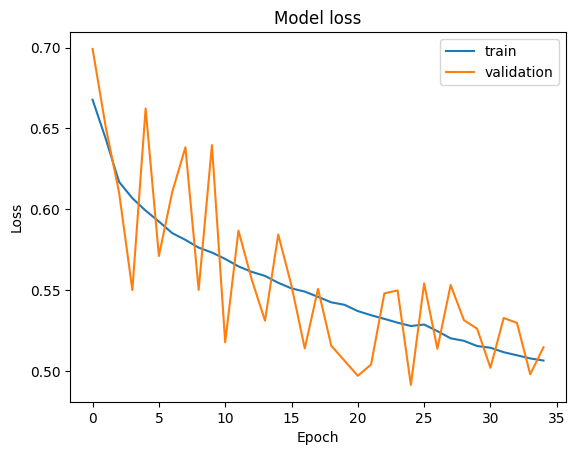

In [ ]:
import matplotlib.pyplot as plt
# Evaluate the model
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# Obtain probabilities (if your last layer uses sigmoid activation)
probabilities = model.predict(X_test)
predictions = (probabilities > 0.8).astype(int)  # convert probabilities to 0 or 1

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'X_test' is not defined

In [8]:
from tensorflow.keras.models import load_model

# Define the file path for saving the model
file_path = "/content/drive/My Drive/Model/stationary_check_model.h5"

# # Save the model
# model.save(file_path)

In [9]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# First split: Separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(features, stationarities, test_size=0.2, random_state=42)

# del features
# del stationarities

# Second split: Separate out the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2



In [10]:
# To load the model
model = load_model(file_path)
model

1415/1415 [==============================] - 9s 6ms/step


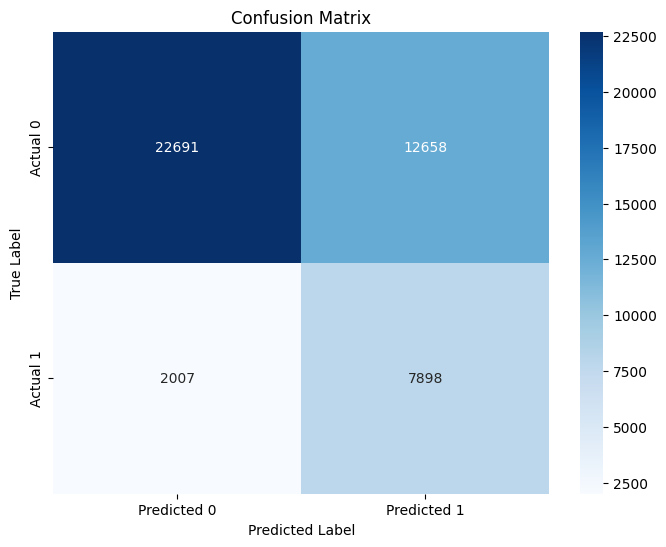

In [13]:
# Obtain probabilities (if your last layer uses sigmoid activation)
probabilities = model.predict(X_test)
predictions = (probabilities > 0.4).astype(int)  # convert probabilities to 0 or 1

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

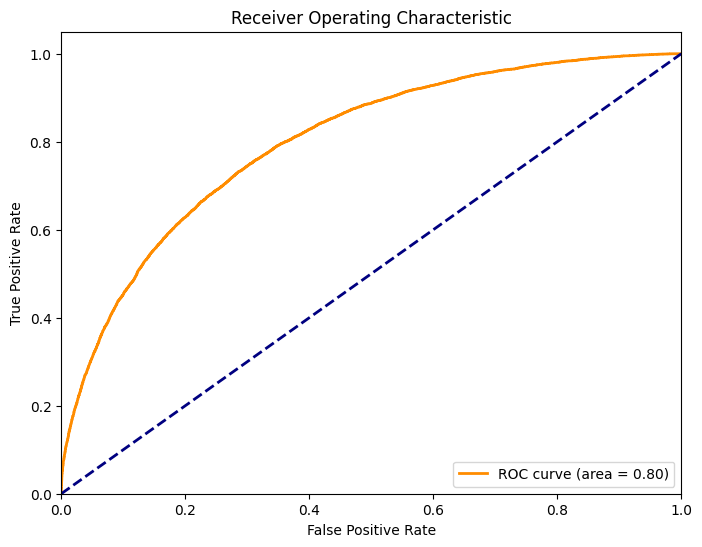

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the fpr, tpr, and thresholds for the roc curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Calculate the AUC (Area under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
